In [1]:
!nvidia-smi

Mon Apr  3 17:27:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   38C    P0    61W / 300W |   4225MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

import scipy as sp
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
import time
import statsmodels.distributions as smd
import os

ML = 5000 #nombre d'echantillons aléatoire
t_init = 0
T  = 10
N1      = 100  # Compute N1 grid points
N2      = 100  # Compute N2 grid points
N3      = 100  # Compute N3 grid points
N4      = 100  # Compute N4 grid points

dt1     = float(T - t_init) / N1 # Compute dt1
dt2     = float(T - t_init) / N2 # Compute dt2
dt3     = float(T - t_init) / N3 # Compute dt3
dt4     = float(T - t_init) / N4 # Compute dt4

ts1    = np.arange(t_init, T, dt1) # Compute grid on [0,T] with dt1
ts2    = np.arange(t_init, T, dt2) # Compute grid on [0,T] with dt2
ts3    = np.arange(t_init, T, dt3) # Compute grid on [0,T] with dt3
ts4    = np.arange(t_init, T, dt4) # Compute grid on [0,T] with dt4


In [3]:
import ModuleFctAlphaa
from ModuleFctAlphaa import *  #Fonction module
from ModuleGeneratorDiscriminator import * #GeneratorDiscrimantor module

In [4]:

'''*********************Data set*********************'''

# Data set on the couple (r,sigma), we sample 50 couples 

ParaFixe=np.zeros((1,2),'f')
ParaFixe[0,0]=0.1  #Sigma parameter for the CIR model
ParaFixe[0,1]=0.01  #Intial point for the CIR model

Sig=ParaFixe[0,0]
S00=ParaFixe[0,1] #Intial point for the CIR model

Nkappa=5
Ntheta=10

Kr=np.zeros(Nkappa,'f')
KrMax=1
KrMin=0.1
Disc=5
Kr=GenerateUnidParameter(KrMax, KrMin, Nkappa, Disc)

ThetaDisc=np.zeros(Ntheta,'f')
thetaMax=1
thetaMin=0.1
Disc=10
ThetaDisc=GenerateUnidParameter(thetaMax, thetaMin, Ntheta, Disc)
Npara=Nkappa*Ntheta
Para=FinalData(Nkappa, Ntheta, ThetaDisc, Kr)
print(Para)

In [6]:
#Generation of the Brwonian increments, the chi-square variables and the M CIR trajectories for different time steps
dW11, SEXC1, CHIT1=CIRMatrix(ts1.size, ML, Sig, Para, S00, T, N1, Npara) #Function returning the ML CIR trajectories using dW11 (brownian motions) and CHIT1 (chi-square variables ) 
dW21, SEXC2, CHIT2=CIRMatrix(ts2.size, ML, Sig, Para, S00, T, N2, Npara)
dW31, SEXC3, CHIT3=CIRMatrix(ts3.size, ML, Sig, Para, S00, T, N3, Npara)
dW41, SEXC4, CHIT4=CIRMatrix(ts4.size, ML, Sig, Para, S00, T, N4, Npara)

In [7]:
#Data Set prepared 
StNumMLL1=FcStNumML(ts1.size, ML, Para, Npara, dt1, SEXC1, dW11, CHIT1)  #Preparation of the data 
StNumMLL2=FcStNumML(ts2.size, ML, Para, Npara, dt2, SEXC2, dW21, CHIT2)
StNumMLL3=FcStNumML(ts3.size, ML, Para, Npara, dt3, SEXC3, dW31, CHIT3)        
StNumMLL4=FcStNumML(ts4.size, ML, Para, Npara, dt4, SEXC4, dW41, CHIT4)


In [8]:
#Data Set Shuffled 
StNumMLL=StNumfctOrderedShuffled(ts1.size, ts2.size, ts3.size, ts4.size, Npara, ML, StNumMLL1, StNumMLL2, StNumMLL3, StNumMLL4)

In [9]:
#Data Set preparation for the splitting phase in the train and the test sets  
StNumPd = pd.DataFrame(data=StNumMLL[:,:]) 
dataset= StNumPd
x= dataset.iloc[:,:-1].values #Input Data 
y= dataset.iloc[:, -1].values #Target Data 

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(x, y, test_size=0.2, random_state= 0) #Splitting data
Ntrain=Y_train.size  #Size of the training set



In [10]:

'''Networks'''

#Generator Network
NetworkG = Generator(input_neurons = 6, hidden_neurons = 200, output_neurons = 1)

#Discriminator Network
NetworkD = Discriminator(input_neurons = 7, hidden_neurons = 200, output_neurons = 1)

'''Optimizers'''

#Generator optimizer Network
optimizerG = torch.optim.Adam(NetworkG.parameters(), lr=0.0001, betas=(0.5, 0.999))
#Discriminator optimizer Network
optimizerD = torch.optim.Adam(NetworkD.parameters(), lr=0.0001, betas=(0.5, 0.999))

'''Loss function'''
#Binary Cross Entropy, BCE, Loss
loss_function = torch.nn.BCELoss()
 

In [81]:
'''************************Training phase*************************'''
    
batche_size=1000   #Batch size 
XYtrain = torch.as_tensor(np.c_[(X_train, Y_train.reshape(-1,1))])
Y0=torch.zeros(batche_size)
Y1=torch.ones(batche_size)
X_train_mini=torch.empty(batche_size, 6)
Y_train_mini=torch.empty(batche_size, 1)

Err_Proba=torch.zeros(0)   #Estimated Probability of having a fake sample 
Err_Descri=torch.zeros(0)  #Discrimnator array loss 
#Arrays that will be needed for savving the most important generators
Err_Genera=torch.zeros(0) #Generator array Loss
EpochTab=torch.zeros(0)  #Array that contains epoch number 
Mini_batchesTab=torch.zeros(0) #Array that contains minibatch number 

NetworkG.train()
NetworkD.train()
#Learning Phase
for epoch in range(10):
    for mini_batches in range(int(Ntrain/batche_size)):
        #MiniBatch data
        X_train_mini.copy_(torch.as_tensor(XYtrain[mini_batches*batche_size:(mini_batches+1)*batche_size,:-1]))
        Y_train_mini.copy_(torch.as_tensor(XYtrain[mini_batches*batche_size:(mini_batches+1)*batche_size,-1:]))
        #Generator output 
        Generator_out = NetworkG(X_train_mini)
        #Discriminator fake input 
        Generator_Descriminator_fake_in=torch.cat((X_train_mini, Generator_out), dim=1) 
        #Discriminator fake ouput 
        Generator_Descriminator_out = NetworkD(Generator_Descriminator_fake_in)
        #Genrator term in the loss function to minimize  
        Generator_loss = -torch.log(Generator_Descriminator_out[:,0]).mean()
        #Genrator network optimizer initialization
        optimizerG.zero_grad()
        #Genrator network backpropagation
        Generator_loss.backward()
        #Genrator network parameters update
        optimizerG.step()
        #Discriminator real input 
        Generator_Descriminator_real_in = torch.cat(( X_train_mini, Y_train_mini.view(-1,1)), dim=1)
        #Revaluation Generator output 
        Generator_out=NetworkG(X_train_mini)
        #Discrimnator fake input with new revaluation 
        Generator_Descriminator_fake_in=torch.cat((X_train_mini, Generator_out.detach()), dim=1)
        
        for epoch2 in range(1):
            
            #Discriminator real output 
            Descriminator_real = NetworkD(Generator_Descriminator_real_in)
            #Second term in the BCE loss function 
            Descriminator_loss_1 = loss_function(Descriminator_real[:,0], Y1)
            #Discriminator fake output 
            Generator_Descriminator_out = NetworkD(Generator_Descriminator_fake_in)
            #Third term in the BCE loss function 
            Descriminator_loss_2 = loss_function(Generator_Descriminator_out[:,0], Y0)
            #Discriminator Loss estimated function to minimize
            Descriminator_loss = Descriminator_loss_1+Descriminator_loss_2
            #Discriminator network optimizer initialization
            optimizerD.zero_grad()
            #Discriminator network backpropagation        
            Descriminator_loss.backward()
            #Discriminator network parameters update
            optimizerD.step()  
        
        print('Probability of success=',Generator_Descriminator_out.mean(),'%')
        print('Error Discriminator=',Descriminator_loss)
        print('Error Generator=',Generator_loss)
        print('Epoch=',epoch)
        GDmTorch=torch.zeros(1)
        DescriTorch=torch.zeros(1)
        GeneraTorch=torch.zeros(1)
        
        GDmTorch[0]=Generator_Descriminator_out.mean().detach()
        DescriTorch[0]=Descriminator_loss.detach()
        GeneraTorch[0]=Generator_loss.detach()
        Err_Proba=torch.cat((Err_Proba, GDmTorch), dim=0)   
        Err_Descri=torch.cat((Err_Descri, DescriTorch), dim=0)
        Err_Genera=torch.cat((Err_Genera, GeneraTorch), dim=0)
        
        #Save important models 
    
        if (epoch >15) & (0.4997<GDmTorch[0]<0.5001):
            last_model_wts = NetworkG.state_dict()
            save_network(NetworkG, epoch, mini_batches)
            Epochh=torch.zeros(1)
            Epochh[0]=(torch.as_tensor(epoch))
            EpochTab=torch.cat((EpochTab, Epochh), dim=0)
            Mini=torch.zeros(1)
            Mini[0]=(torch.as_tensor(mini_batches))   
            Mini_batchesTab=torch.cat((Mini_batchesTab, Mini), dim=0)


KeyboardInterrupt: 

tensor([0.3809, 0.4911, 0.5520,  ..., 0.5000, 0.5000, 0.5000])


No handles with labels found to put in legend.


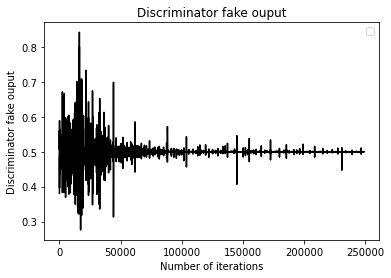

In [34]:
#Convergence Discriminator fake output
print(Err_Proba )
(Err_Proba).size()
plt.plot( Err_Proba,'black') 
# naming of x-axis and y-axis
plt.xlabel("Number of iterations")
plt.ylabel("Discriminator fake ouput")
 
# naming the title of the plot
plt.title("Discriminator fake ouput")
plt.legend()

In [35]:
                            """Test-Phase"""
'''CIR test Model '''
#We use here different test trajectories than those already prepared to have a control on the parameters, it doesn't change anything
ML=10000   #Number of trajectories for the test phase
theta=0.3  #Theta parameter for the test phase
kappa=0.3  #Kappa parameter for the test phase
N1=100 

S0=(S00)*np.ones(ML,dtype=np.float32)
SexcT, dW, chiTest11 = CIR_generate_paths_testCase(S0, kappa, theta, Sig, T, N1, ML) #Generation of the CIR test trajectories 
StNumMLLt=FctNumMltest(ts1.size, ML, theta, kappa, dt1, SexcT, dW, chiTest11) #Data preparation

In [79]:
batchesize=100
loss_function2= torch.nn.MSELoss()  #Mean square Loss function
StNumPd = pd.DataFrame(data=StNumMLLt[:,:]) 
dataset= StNumPd
x= dataset.iloc[:,:-1].values
y= dataset.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(x, y, test_size=0.5, random_state= 0)



In [ ]:
"""CIR Generator"""
#Here we take the last generator obtained from the training phase 
Ntest=Y_test.size
X_test_torch=torch.zeros(Ntest, 6)
X_test_torch.copy_(torch.as_tensor(X_test))
Generator_test_full=torch.zeros((Ntest))
X_test_full=X_test_torch[0,:]
MLi=4
NSt=10**4
for j in range(MLi):
    for i in range(NSt+1):
              Generator_test_full[i+j*(NSt+1)] = abs(NetworkG(X_test_full)*theta+theta)
              X_test_torch[i+1+j*(NSt+1),0]=Generator_test_full[i+j*(NSt+1)]
              X_test_full = X_test_torch[i+1+j*(NSt+1),:]


In [67]:
"""Choice of the generator for the test phase"""
#Here we can choose one of the saved generator by adding the Id Generator parametrized by its minibatch and epoch number 
X_test_torch=torch.zeros(Ntest, 6)
X_test_torch.copy_(torch.as_tensor(X_test))
Generator_test_full=torch.zeros((Ntest))
X_test_full=X_test_torch[0,:]
ML=1
NSt=47
#for l in range(EpochTab.size()[0]):
    #PATH="./SavedModels102/net_{}_{}.pth".format(int(EpochTab[l]) , int(Mini_batchesTab[l])) #We can do it manually 
PATH="./SavedModels102/net_G_theta_kappa.pth"#To be changed with your Id genrator 
checkpoint = torch.load(PATH)
NetworkG.load_state_dict(checkpoint)
NetworkG.eval()
for j in range(ML):
    for i in range(NSt+1):
              #Generator_test_full[i] = abs(NetworkG(X_test_full)*theta+theta)
        Generator_test_full[i+j*(NSt+1)] = abs(NetworkG(X_test_full)*theta+theta)
        X_test_torch[i+1+j*(NSt+1),0]=Generator_test_full[i+j*(NSt+1)]
        X_test_full = X_test_torch[i+1+j*(NSt+1),:]

In [69]:
                                """Results""" 
    
                                #R2_score value
print("R2=",r2_score(Y_test[:40000],(Generator_test_full[:40000]).detach().cpu().numpy()))
                        #Relative mean square error in percent 
RelErrL2=np.zeros(1)
Y_test_torch=torch.zeros(Ntest)
Y_test_torch.copy_(torch.as_tensor(Y_test))
N=20000
r=0
for i in range(N):
    if Y_test_torch[i]!=0 : 
        r=r+((Y_test_torch[i]-Generator_test_full[i])/Y_test_torch[i])**2
RelErrL2=(np.sqrt(r.detach().cpu().numpy()/N))*100
print("Relative Mean square Error=", RelErrL2,"%")



R2= 0.9730708095990296
Relative Mean square Error= 8.737852983889487 %


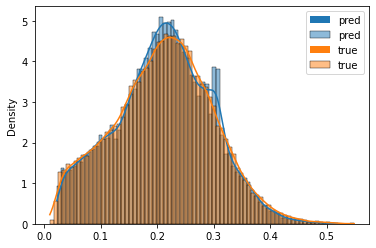

In [78]:
            #Empirical conditional Distributions, real and fake 
sns.histplot((Generator_test_full[:40000]).detach().cpu().numpy(), label = 'pred', kde=True, stat="density")
sns.histplot(Y_test[:40000],  label = 'true' , kde=True, stat="density")
plt.legend()
 

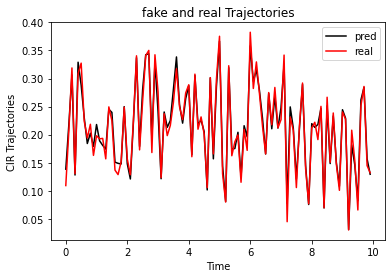

In [71]:
                   #Plot some trajectories 
dt=0.1
T=10
Tin=0
x = np.arange(Tin, T, dt)
i=2 #We can change this to see different trajectories 
Nt=int((T-Tin)/dt)
plt.plot(x, Generator_test_full.detach().cpu().numpy()[i*Nt:(i+1)*Nt],'black', label = 'pred')
plt.plot(x, Y_test[i*Nt:(i+1)*Nt],'red', label = 'real')
# naming of x-axis and y-axis
plt.xlabel("Time")
plt.ylabel("CIR Trajectories")
# naming the title of the plot
plt.title("fake and real Trajectories")
plt.legend()
plt.show()

                    """End of the algorithm, thank you"""